### (6) Plotting routines

All the plotting routines for the full model, note that GemPy model needs to be recalculated here.

In [1]:
# Import dependencies
import gempy as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import gstools as gs
import pyvista as pv
import pyvistaqt as pvqt
import PVGeo
import matplotlib

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.precision', 2)

### 1. Reload and recalcualte Geo-structural model

In [2]:
# Load model from notebook (2)
geo_data = gp.load_model('Geo-structural model NJ shelf')

# Set interpolator
interp_data = gp.set_interpolator(geo_data, compile_theano=True,
                                  theano_optimizer='fast_compile')

# Compute model solution
sol = gp.compute_model(geo_data)

Active grids: ['regular']
Setting kriging parameters to their default values.
Compiling aesara function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                                       values
range                              150731.18
$C_o$                            540949761.9
drift equations  [3, 3, 3, 3, 3, 3, 3, 3, 3]


### 2. Loading porosity well data)

In [3]:
# Load data 
df = pd.read_csv("Data/Wells/Complete_set_corrected.csv")
df.head()

,X,Y,Z,Porosity,Sequence,Well
0,28200,76200,-372.13,10.7,m54,m28
1,28200,76200,-568.73,13.3,m58,m28
2,28200,76200,-671.83,15.0,m58,m28
3,28200,76200,-693.95,15.6,m58,m28
4,28200,76200,-692.00,16.0,m58,m28


### 3. Loading realization of porosity model

In [4]:
results_df = pd.read_csv("Results/Model_realization_20210728.csv")
results_df.head()

,X,Y,Z,Porosity,Sequence
0,250.0,250.0,-30.0,43.23,m1
1,250.0,750.0,-30.0,37.98,m1
2,250.0,1250.0,-30.0,35.32,m1
3,250.0,1750.0,-30.0,37.96,m1
4,250.0,2250.0,-30.0,38.46,m1


### 4. Plotting full 3D model

In [6]:
# Plot full model without gempy

#cmap = plt.cm.get_cmap("viridis", 6)
p = pvqt.BackgroundPlotter()

pc = pv.PolyData(np.c_[results_df["X"].values, results_df["Y"].values, results_df["Z"].values])

pc["Porosity"]=results_df["Porosity"].values

spacing = lambda arr: np.unique(np.diff(np.unique(arr)))
voxelsize = spacing(pc.points[:,0]), spacing(pc.points[:,1]), spacing(pc.points[:,2])

pc = pc.cast_to_unstructured_grid()

grid = PVGeo.filters.VoxelizePoints(dx=voxelsize[0][0], dy=voxelsize[1][0], dz=voxelsize[2][0], estimate=False).apply(pc)
    
#p.add_mesh(grid, opacity=1, show_edges=False, lighting=False, cmap=cmap)
#p.add_mesh(grid, opacity=1, show_edges=False, lighting=False, cmap="viridis")
p.add_mesh(grid, scalars="Porosity", opacity=1, show_edges=False, lighting=False, cmap="viridis", clim=[results_df["Porosity"].min(), results_df["Porosity"].max()])

p.set_scale(zscale=30)
p.camera_position = (320, 200, 3)
p.show_grid(xlabel="X [m]", ylabel="Y [m]", zlabel="Z [m]")

p.show()

In [10]:
# Plot full model with gempy

gpv = gp.plot_3d(geo_data, plotter_type='background', show_data=False, show_surfaces=False, show_lith=True)
cmap = plt.cm.get_cmap("viridis", 10)
    
gpv.p.add_mesh(grid, opacity=1, show_edges=False, lighting=False, cmap=cmap)
#gpv.p.add_mesh(grid, opacity=1, show_edges=False, lighting=False, cmap="viridis")

gpv.p.show_grid(xlabel="X [m]", ylabel="Y [m]", zlabel="Z [m]")
gpv.p.hide_axes_all()
gpv.p.set_scale(zscale=30)
gpv.p.camera_position = (320, 200, 3)

gpv.p.show()

### 5. Plotting structural sections

<Figure size 1040x715 with 0 Axes>

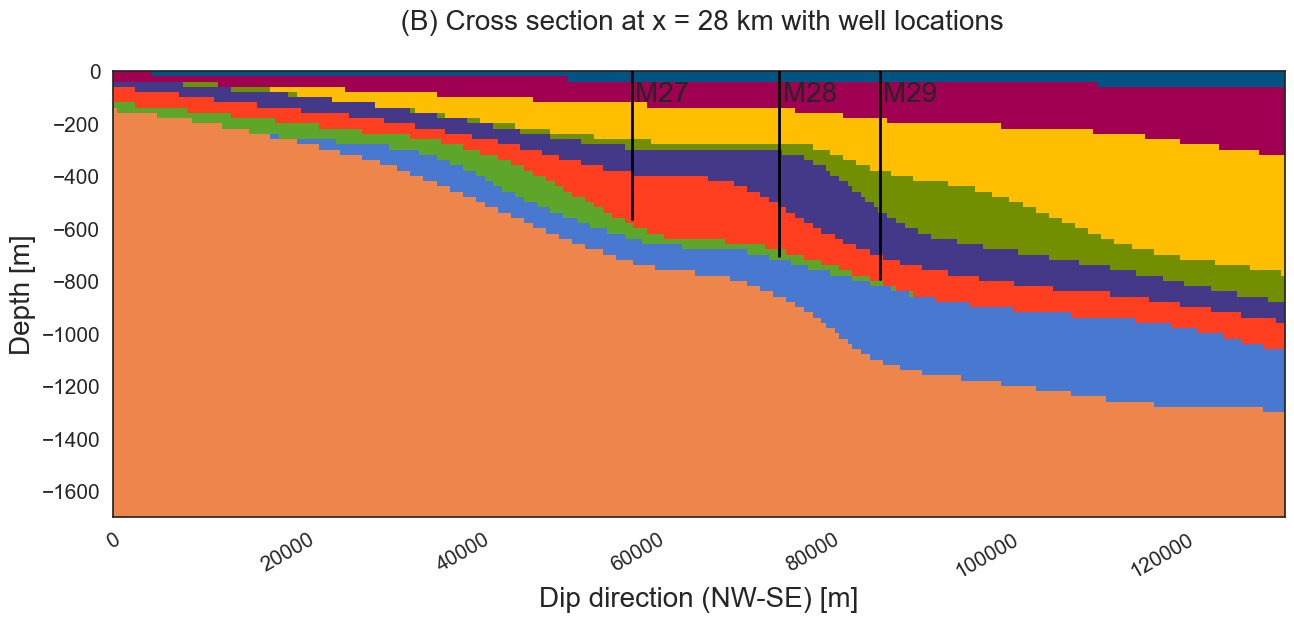

In [11]:
# Dip section at cell n=56, roughly well location
n = 56

fig=plt.figure()

fig.p = gp.plot_2d(geo_data, cell_number=n, direction="x", show_data=False, show_lith=True, show_boundaries=False, 
                   ve=30, figsize=(14,5))

fig.p.axes[0].set_xlim(geo_data.grid.regular_grid.extent[2], geo_data.grid.regular_grid.extent[3])
fig.p.axes[0].set_ylim(geo_data.grid.regular_grid.extent[4], geo_data.grid.regular_grid.extent[5])
fig.p.axes[0].set_ylabel("Depth [m]", fontsize=20)
fig.p.axes[0].set_xlabel("Dip direction (NW-SE) [m]", fontsize=20)
fig.p.axes[0].set_title(" (B) Cross section at x = 28 km with well locations", fontsize=20, pad=30)

# Make wells full lines
fig.p.axes[0].plot([df[df["Well"]=="m27"]["Y"].values[0], df[df["Well"]=="m27"]["Y"].values[0]], 
                    [0, df[df["Well"]=="m27"]["Z"].values.min()], c="black", zorder=100, label="M27", linewidth=2)
fig.p.axes[0].plot([df[df["Well"]=="m28"]["Y"].values[0], df[df["Well"]=="m28"]["Y"].values[0]], 
                    [0, df[df["Well"]=="m28"]["Z"].values.min()], c="black", zorder=100, label="M28", linewidth=2)
fig.p.axes[0].plot([df[df["Well"]=="m29"]["Y"].values[0], df[df["Well"]=="m29"]["Y"].values[0]], 
                    [0, df[df["Well"]=="m29"]["Z"].values.min()], c="black", zorder=100, label="M29", linewidth=2)

# Well labels
plt.text(df[df["Well"]=="m27"]["Y"].values[0]+400, -115, 'M27', zorder =100,  fontsize=20)
plt.text(df[df["Well"]=="m28"]["Y"].values[0]+400, -115, 'M28', zorder =100,  fontsize=20)
plt.text(df[df["Well"]=="m29"]["Y"].values[0]+400, -115, 'M29', zorder =100,  fontsize=20)

fig.p.axes[0].tick_params(axis='both', which='major', labelsize=15)

plt.savefig("Figures/Cross_section_structural_dip", bbox_inches="tight")

fig.show()

<Figure size 1040x715 with 0 Axes>

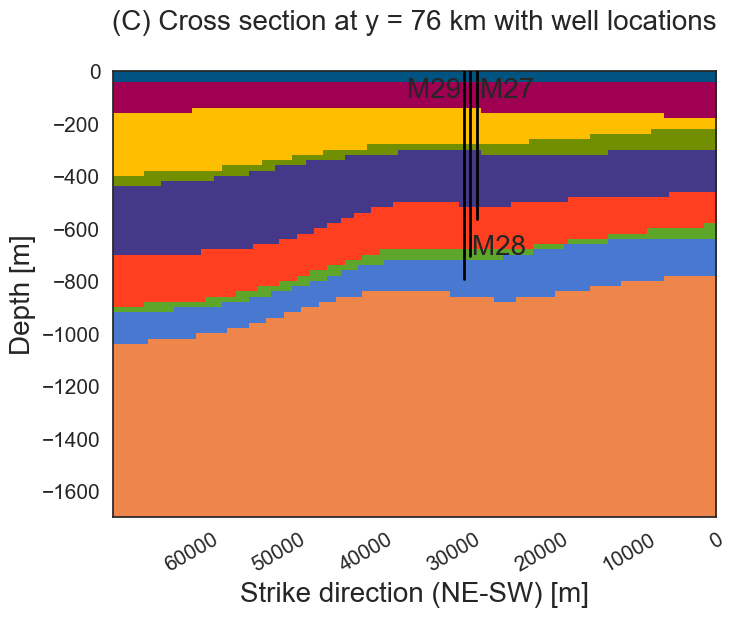

In [12]:
# Strike section at cell n=152, roughly well location
n = 152

fig=plt.figure()

fig.p = gp.plot_2d(geo_data, cell_number=n, direction="y", show_data=False, show_lith=True, show_boundaries=False, 
                   ve=30, figsize=(14,5))

fig.p.axes[0].set_xlim(geo_data.grid.regular_grid.extent[0], geo_data.grid.regular_grid.extent[1])
fig.p.axes[0].set_ylim(geo_data.grid.regular_grid.extent[4], geo_data.grid.regular_grid.extent[5])
fig.p.axes[0].set_ylabel("Depth [m]", fontsize=20)
fig.p.axes[0].set_xlabel("Strike direction (NE-SW) [m]", fontsize=20)
fig.p.axes[0].set_title("(C) Cross section at y = 76 km with well locations", fontsize=20, pad=30)
fig.p.axes[0].invert_xaxis()

# Make wells full lines
fig.p.axes[0].plot([df[df["Well"]=="m27"]["X"].values[0], df[df["Well"]=="m27"]["X"].values[0]], 
                    [0, df[df["Well"]=="m27"]["Z"].values.min()], c="black", zorder=100, label="M27", linewidth=2)
fig.p.axes[0].plot([df[df["Well"]=="m28"]["X"].values[0], df[df["Well"]=="m28"]["X"].values[0]], 
                    [0, df[df["Well"]=="m28"]["Z"].values.min()], c="black", zorder=100, label="M28", linewidth=2)
fig.p.axes[0].plot([df[df["Well"]=="m29"]["X"].values[0], df[df["Well"]=="m29"]["X"].values[0]], 
                    [0, df[df["Well"]=="m29"]["Z"].values.min()], c="black", zorder=100, label="M29", linewidth=2)

# Well labels
plt.text(df[df["Well"]=="m27"]["X"].values[0]-400, -100, 'M27', zorder =100,  fontsize=20)
plt.text(df[df["Well"]=="m28"]["X"].values[0]-300, -700, 'M28', zorder =100,  fontsize=20)
plt.text(df[df["Well"]=="m29"]["X"].values[0]+6500, -100, 'M29', zorder =100,  fontsize=20)

fig.p.axes[0].set_aspect(30)
fig.p.axes[0].tick_params(axis='both', which='major', labelsize=15)

plt.savefig("Figures/Cross_section_structural_strike", bbox_inches="tight")

fig.show()

In [13]:
# 3D model with section lines

# view model 3D
gpv = gp.plot_3d(geo_data, ve=30, plotter_type='background', show_data=False)
gpv.p.camera_position = (320, 200,3)

# Make two points to construct the line between
a1 = [28000, 0, 20]
b1 = [28000, 134000, 20]

a2 = [0, 76000, 20]
b2 = [69000, 76000, 20]

# Preview how this line intersects this mesh
line1 = pv.Line(a1, b1)
line2 = pv.Line(a2, b2)

gpv.p.add_mesh(line1, color="grey", line_width=5)
gpv.p.add_mesh(line2, color="grey", line_width=5)

gpv.p.add_point_labels([a1, b1], ["A", "A'"], font_size=20, point_color="black", text_color="black")
gpv.p.add_point_labels([a2, b2], ["B", "B'"], font_size=20, point_color="black", text_color="black")

gpv.p.camera_position = (320, 200,5)
gpv.p.hide_axes_all()
gpv.p.show_grid(xlabel="X [m]", ylabel="Y [m]", zlabel="Z [m]")

<CubeAxesActor(0x000001F4EF455CC0) at 0x000001F3B62AE920>

### 6. Plotting porosity sections

In [14]:
# Routine for putting result back into model
rounded_lithblock = sol.lith_block.round(0)
rounded_lithblock = rounded_lithblock.astype(int)

por_block = rounded_lithblock.copy()

for i in np.arange(2,9):
    # mask by array of input surfaces (by id, can be from different series)
    mask = np.isin(rounded_lithblock, i)

    seq = str(np.unique(results_df["Sequence"])[i-2])
    
    test = results_df[results_df["Sequence"]==seq]
    
    por_block[mask]=test["Porosity"].values

# reshape and zero out basement and seafloor
por_block = por_block.reshape(geo_data.grid.regular_grid.resolution);
por_block[por_block==9]=0
por_block[por_block==1]=0

<Figure size 3000x3000 with 0 Axes>

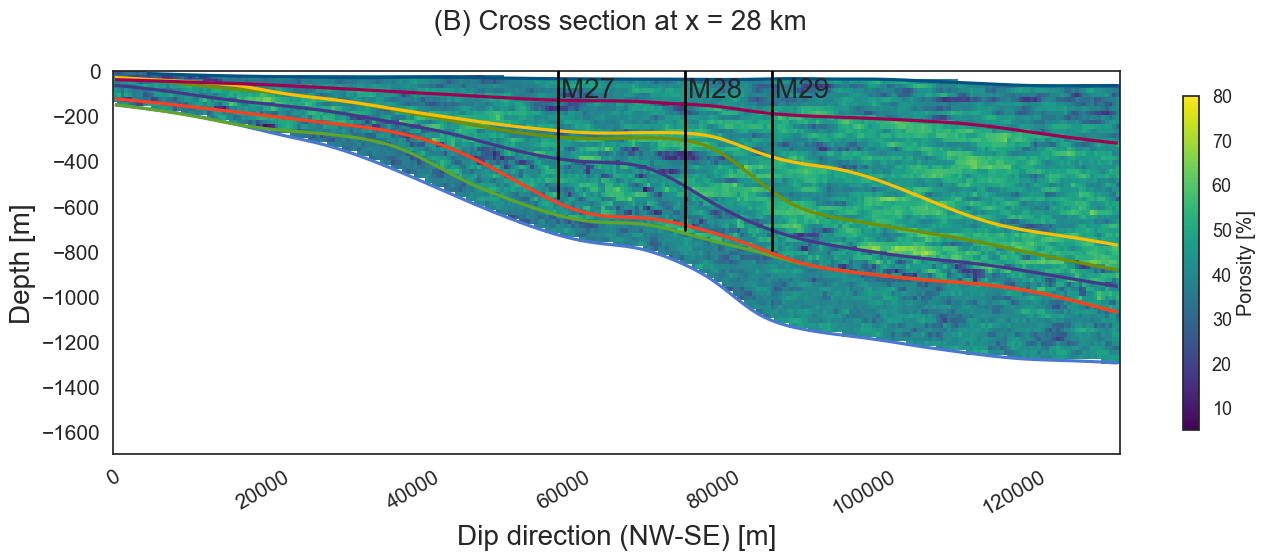

In [15]:
# Dip section at cell n=56, roughly well location

n = 56

fig=plt.figure(figsize=(30,30))
fig.suptitle("Cross section")

fig.p = gp.plot_2d(geo_data, cell_number=n, direction="x", show_data=False, show_lith=False, ve=30, figsize=(14,5))

section = por_block[n,:,:].T

# Mask data == 0
section = np.ma.masked_where(section <=0, section)

# cmap = plt.cm.get_cmap("viridis", 10)
cmap = plt.cm.get_cmap("viridis")
cmap.set_bad(color='white', alpha = 1)

c=fig.p.axes[0].imshow(section, extent=geo_data.grid.regular_grid.extent[2:], cmap=cmap, origin='lower', clim=[5,80])
fig.p.axes[0].set_xlim(geo_data.grid.regular_grid.extent[2], geo_data.grid.regular_grid.extent[3])
fig.p.axes[0].set_ylim(geo_data.grid.regular_grid.extent[4], geo_data.grid.regular_grid.extent[5])
fig.p.axes[0].set_ylabel("Depth [m]", fontsize=20)
fig.p.axes[0].set_xlabel("Dip direction (NW-SE) [m]", fontsize=20)
fig.p.axes[0].set_title(" (B) Cross section at x = 28 km", fontsize=20, pad=30)

# Make wells full lines
fig.p.axes[0].plot([df[df["Well"]=="m27"]["Y"].values[0], df[df["Well"]=="m27"]["Y"].values[0]], 
                    [0, df[df["Well"]=="m27"]["Z"].values.min()], c="black", zorder=100, label="M27", linewidth=2)
fig.p.axes[0].plot([df[df["Well"]=="m28"]["Y"].values[0], df[df["Well"]=="m28"]["Y"].values[0]], 
                    [0, df[df["Well"]=="m28"]["Z"].values.min()], c="black", zorder=100, label="M28", linewidth=2)
fig.p.axes[0].plot([df[df["Well"]=="m29"]["Y"].values[0], df[df["Well"]=="m29"]["Y"].values[0]], 
                    [0, df[df["Well"]=="m29"]["Z"].values.min()], c="black", zorder=100, label="M29", linewidth=2)

# Well labels
plt.text(df[df["Well"]=="m27"]["Y"].values[0]+400, -115, 'M27', zorder =100,  fontsize=20)
plt.text(df[df["Well"]=="m28"]["Y"].values[0]+400, -115, 'M28', zorder =100,  fontsize=20)
plt.text(df[df["Well"]=="m29"]["Y"].values[0]+400, -115, 'M29', zorder =100,  fontsize=20)

fig.p.axes[0].set_aspect(30)

plt.colorbar(c, shrink=0.75, label="Porosity [%]")

fig.p.axes[0].tick_params(axis='both', which='major', labelsize=15)

plt.savefig("Figures/Cross_section_por_dip", bbox_inches="tight")

<Figure size 1040x715 with 0 Axes>

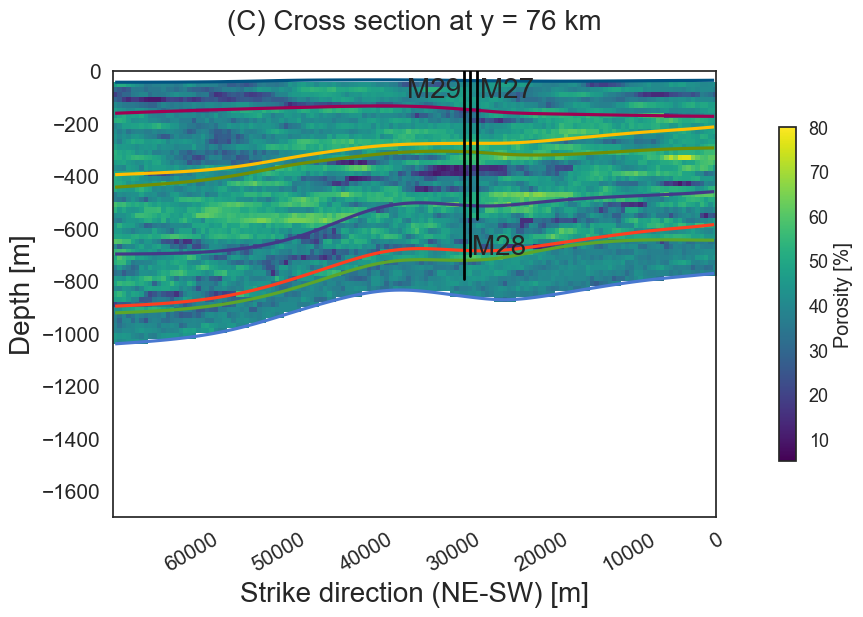

In [16]:
# Strike section at cell n=152, roughly well location
n = 152

fig=plt.figure()

fig.p = gp.plot_2d(geo_data, cell_number=n, direction="y", show_data=False, show_lith=False, show_boundaries=True, 
                   ve=30, figsize=(14,5))

section = por_block[:,n,:].T

section = np.ma.masked_where(section <=0, section)

# cmap = plt.cm.get_cmap("viridis", 10)
cmap = plt.cm.get_cmap("viridis")
cmap.set_bad(color='white', alpha = 1)

c=fig.p.axes[0].imshow(section, extent=[0, 69000, -1700, 0], cmap=cmap, origin='lower', clim=[5,80])

fig.p.axes[0].set_xlim(geo_data.grid.regular_grid.extent[0], geo_data.grid.regular_grid.extent[1])
fig.p.axes[0].set_ylim(geo_data.grid.regular_grid.extent[4], geo_data.grid.regular_grid.extent[5])

fig.p.axes[0].set_ylabel("Depth [m]", fontsize=20)
fig.p.axes[0].set_xlabel("Strike direction (NE-SW) [m]", fontsize=20)
fig.p.axes[0].set_title("(C) Cross section at y = 76 km", fontsize=20, pad=30)
fig.p.axes[0].invert_xaxis()


# Make wells full lines
fig.p.axes[0].plot([df[df["Well"]=="m27"]["X"].values[0], df[df["Well"]=="m27"]["X"].values[0]], 
                    [0, df[df["Well"]=="m27"]["Z"].values.min()], c="black", zorder=100, label="M27", linewidth=2)
fig.p.axes[0].plot([df[df["Well"]=="m28"]["X"].values[0], df[df["Well"]=="m28"]["X"].values[0]], 
                    [0, df[df["Well"]=="m28"]["Z"].values.min()], c="black", zorder=100, label="M28", linewidth=2)
fig.p.axes[0].plot([df[df["Well"]=="m29"]["X"].values[0], df[df["Well"]=="m29"]["X"].values[0]], 
                    [0, df[df["Well"]=="m29"]["Z"].values.min()], c="black", zorder=100, label="M29", linewidth=2)

# Well lables
plt.text(df[df["Well"]=="m27"]["X"].values[0]-400, -100, 'M27', zorder =100,  fontsize=20)
plt.text(df[df["Well"]=="m28"]["X"].values[0]-300, -700, 'M28', zorder =100,  fontsize=20)
plt.text(df[df["Well"]=="m29"]["X"].values[0]+6500, -100, 'M29', zorder =100,  fontsize=20)

fig.p.axes[0].set_aspect(30)
fig.p.axes[0].tick_params(axis='both', which='major', labelsize=15)

plt.colorbar(c, shrink=0.75, label="Porosity [%]")

plt.savefig("Figures/Cross_section_por_strike", bbox_inches="tight")

fig.show()

In [17]:
# Location of sections in 3D model

#cmap = plt.cm.get_cmap("viridis", 6)
p = pvqt.BackgroundPlotter()

pc = pv.PolyData(np.c_[results_df["X"].values, results_df["Y"].values, results_df["Z"].values])

pc["Porosity"]=results_df["Porosity"].values

spacing = lambda arr: np.unique(np.diff(np.unique(arr)))
voxelsize = spacing(pc.points[:,0]), spacing(pc.points[:,1]), spacing(pc.points[:,2])

pc = pc.cast_to_unstructured_grid()

grid = PVGeo.filters.VoxelizePoints(dx=voxelsize[0][0], dy=voxelsize[1][0], dz=voxelsize[2][0], estimate=False).apply(pc)
    
#p.add_mesh(grid, opacity=1, show_edges=False, lighting=False, cmap=cmap)
#p.add_mesh(grid, opacity=1, show_edges=False, lighting=False, cmap="viridis")
p.add_mesh(grid, scalars="Porosity", opacity=1, show_edges=False, lighting=False, cmap="viridis", clim=[results_df["Porosity"].min(), results_df["Porosity"].max()])

# Make two points to construct the line between
a1 = [28000, 0, 20]
b1 = [28000, 134000, 20]

a2 = [0, 76000, 20]
b2 = [69000, 76000, 20]

# Preview how this line intersects this mesh
line1 = pv.Line(a1, b1)
line2 = pv.Line(a2, b2)

p.add_mesh(line1, color="grey", line_width=5)
p.add_mesh(line2, color="grey", line_width=5)

p.add_point_labels([a1, b1], ["A", "A'"], font_size=20, point_color="black", text_color="black")
p.add_point_labels([a2, b2], ["B", "B'"], font_size=20, point_color="black", text_color="black")

p.camera_position = (320, 200,150)
p.set_scale(zscale=30)
p.hide_axes_all()
p.show_grid(xlabel="X [m]", ylabel="Y [m]", zlabel="Z [m]")

p.show()

### Plotting permeability sections

In [18]:
### Here load model
results_df_perm = pd.read_csv("Results/Model_realization_por-perm_20210728.csv") # probably better all in one

In [19]:
# Routine for putting result back into model
rounded_lithblock = sol.lith_block.round(0)
rounded_lithblock = rounded_lithblock.astype(int)

perm_block = rounded_lithblock.copy().astype("float64")

for i in np.arange(2,9):
    # mask by array of input surfaces (by id, can be from different series)
    mask = np.isin(rounded_lithblock, i)

    seq = str(np.unique(results_df_perm["Sequence"])[i-2])
    
    test = results_df_perm[results_df_perm["Sequence"]==seq]
    
    perm_block[mask]=test["Permeability"].values

# Reshape and zero out basement and seafloor
perm_block = perm_block.reshape(geo_data.grid.regular_grid.resolution);
perm_block[perm_block==9]=0
perm_block[perm_block==1]=0

<Figure size 3000x3000 with 0 Axes>

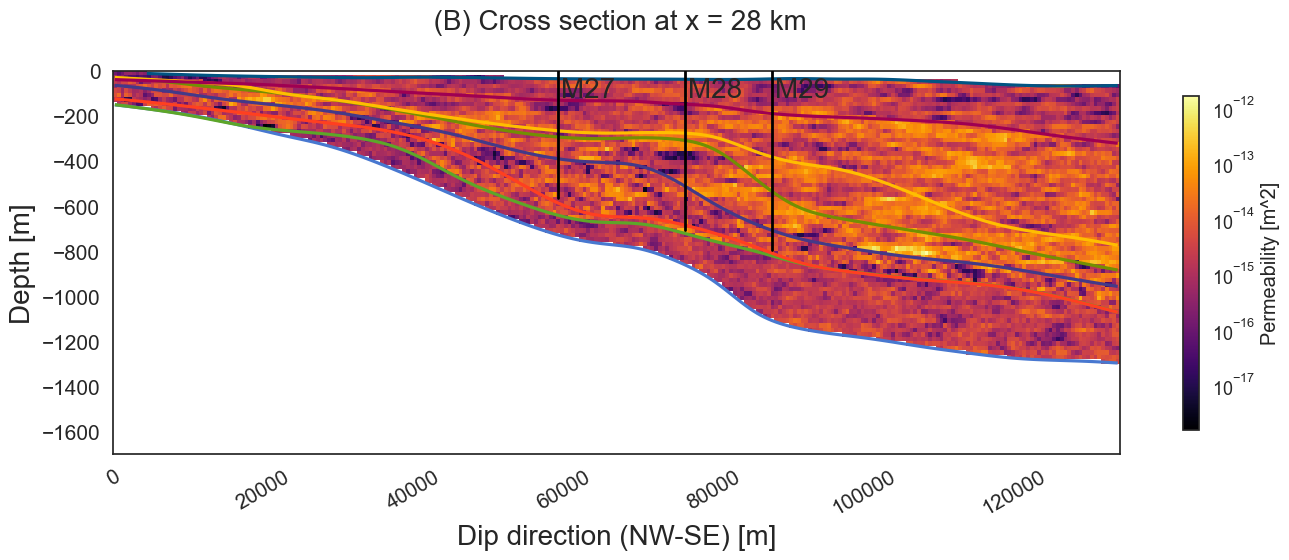

In [20]:
# Dip section at cell n=56, roughly well location
n = 56

fig=plt.figure(figsize=(30,30))
fig.suptitle("Cross section")

fig.p = gp.plot_2d(geo_data, cell_number=n, direction="x", show_data=False, show_lith=False, ve=30, figsize=(14,5))

section = perm_block[n,:,:].T

# Mask data == 00
section = np.ma.masked_where(section <=0, section)

#cmap = plt.cm.get_cmap("viridis", 10)
cmap = plt.cm.get_cmap("inferno")
cmap.set_bad(color='white', alpha = 1)

c=fig.p.axes[0].imshow(section, extent=geo_data.grid.regular_grid.extent[2:], cmap=cmap, 
                       norm=matplotlib.colors.LogNorm(), origin='lower')
fig.p.axes[0].set_xlim(geo_data.grid.regular_grid.extent[2], geo_data.grid.regular_grid.extent[3])
fig.p.axes[0].set_ylim(geo_data.grid.regular_grid.extent[4], geo_data.grid.regular_grid.extent[5])
fig.p.axes[0].set_ylabel("Depth [m]", fontsize=20)
fig.p.axes[0].set_xlabel("Dip direction (NW-SE) [m]", fontsize=20)
fig.p.axes[0].set_title(" (B) Cross section at x = 28 km", fontsize=20, pad=30)

# Make wells full lienes instead
fig.p.axes[0].plot([df[df["Well"]=="m27"]["Y"].values[0], df[df["Well"]=="m27"]["Y"].values[0]], 
                    [0, df[df["Well"]=="m27"]["Z"].values.min()], c="black", zorder=100, label="M27", linewidth=2)
fig.p.axes[0].plot([df[df["Well"]=="m28"]["Y"].values[0], df[df["Well"]=="m28"]["Y"].values[0]], 
                    [0, df[df["Well"]=="m28"]["Z"].values.min()], c="black", zorder=100, label="M28", linewidth=2)
fig.p.axes[0].plot([df[df["Well"]=="m29"]["Y"].values[0], df[df["Well"]=="m29"]["Y"].values[0]], 
                    [0, df[df["Well"]=="m29"]["Z"].values.min()], c="black", zorder=100, label="M29", linewidth=2)

# Well labels
plt.text(df[df["Well"]=="m27"]["Y"].values[0]+400, -115, 'M27', zorder =100,  fontsize=20)
plt.text(df[df["Well"]=="m28"]["Y"].values[0]+400, -115, 'M28', zorder =100,  fontsize=20)
plt.text(df[df["Well"]=="m29"]["Y"].values[0]+400, -115, 'M29', zorder =100,  fontsize=20)

fig.p.axes[0].set_aspect(30)

plt.colorbar(c, shrink=0.75, label="Permeability [m^2]")

fig.p.axes[0].tick_params(axis='both', which='major', labelsize=15)

plt.savefig("Figures/Cross_section_perm_dip", bbox_inches="tight")


<Figure size 1040x715 with 0 Axes>

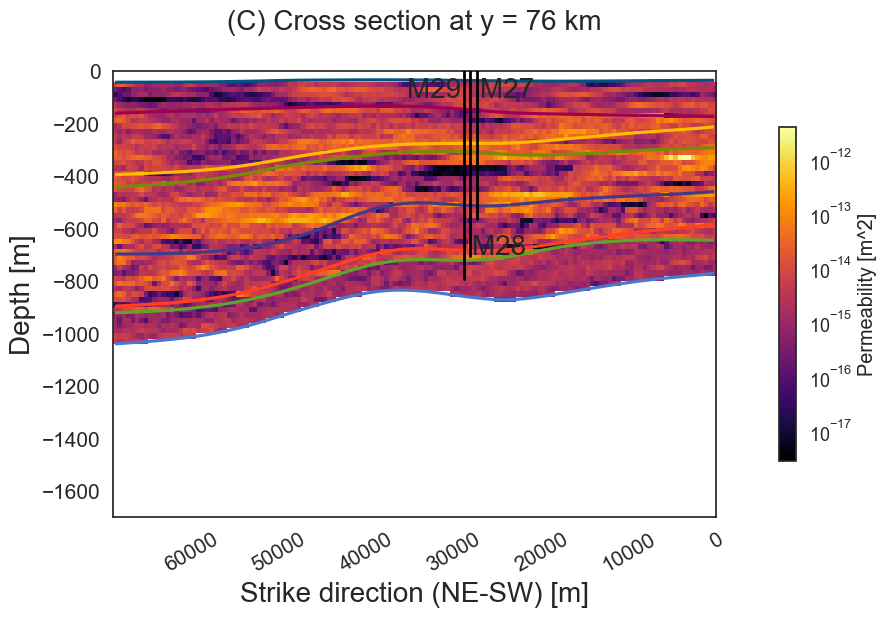

In [21]:
# Strike section at cell n=152, roughly well location
n = 152

fig=plt.figure()

fig.p = gp.plot_2d(geo_data, cell_number=n, direction="y", show_data=False, show_lith=False, show_boundaries=True, 
                   ve=30, figsize=(14,5))

section = perm_block[:,n,:].T

section = np.ma.masked_where(section <=0, section)

#cmap = plt.cm.get_cmap("viridis", 10)
cmap = plt.cm.get_cmap("inferno")
cmap.set_bad(color='white', alpha = 1)

c=fig.p.axes[0].imshow(section, extent=[0, 69000, -1700, 0], cmap=cmap, 
                       norm=matplotlib.colors.LogNorm(), origin='lower')

fig.p.axes[0].set_xlim(geo_data.grid.regular_grid.extent[0], geo_data.grid.regular_grid.extent[1])
fig.p.axes[0].set_ylim(geo_data.grid.regular_grid.extent[4], geo_data.grid.regular_grid.extent[5])

fig.p.axes[0].set_ylabel("Depth [m]", fontsize=20)
fig.p.axes[0].set_xlabel("Strike direction (NE-SW) [m]", fontsize=20)
fig.p.axes[0].set_title("(C) Cross section at y = 76 km", fontsize=20, pad=30)
fig.p.axes[0].invert_xaxis()


# Make wells full lines
fig.p.axes[0].plot([df[df["Well"]=="m27"]["X"].values[0], df[df["Well"]=="m27"]["X"].values[0]], 
                    [0, df[df["Well"]=="m27"]["Z"].values.min()], c="black", zorder=100, label="M27", linewidth=2)
fig.p.axes[0].plot([df[df["Well"]=="m28"]["X"].values[0], df[df["Well"]=="m28"]["X"].values[0]], 
                    [0, df[df["Well"]=="m28"]["Z"].values.min()], c="black", zorder=100, label="M28", linewidth=2)
fig.p.axes[0].plot([df[df["Well"]=="m29"]["X"].values[0], df[df["Well"]=="m29"]["X"].values[0]], 
                    [0, df[df["Well"]=="m29"]["Z"].values.min()], c="black", zorder=100, label="M29", linewidth=2)

# Well labels
plt.text(df[df["Well"]=="m27"]["X"].values[0]-400, -100, 'M27', zorder =100,  fontsize=20)
plt.text(df[df["Well"]=="m28"]["X"].values[0]-300, -700, 'M28', zorder =100,  fontsize=20)
plt.text(df[df["Well"]=="m29"]["X"].values[0]+6500, -100, 'M29', zorder =100,  fontsize=20)

fig.p.axes[0].set_aspect(30)
fig.p.axes[0].tick_params(axis='both', which='major', labelsize=15)

plt.colorbar(c, shrink=0.75, label="Permeability [m^2]")

plt.savefig("Figures/Cross_section_perm_strike", bbox_inches="tight")

fig.show()

### Plotting well comparison

In [22]:
# Mask by closest grid location
maskM27 = (results_df["X"].values==27250) & (results_df["Y"].values==59250)
maskM28 = (results_df["X"].values==28250) & (results_df["Y"].values==76250)
maskM29 = (results_df["X"].values==28750) & (results_df["Y"].values==87750)

# Mask and sort
resM27 = results_df[maskM27].sort_values("Z")
resM28 = results_df[maskM28].sort_values("Z")
resM29 = results_df[maskM29].sort_values("Z")

df = df.sort_values("Z")

Text(0.5, 0, 'Porosity [%]')

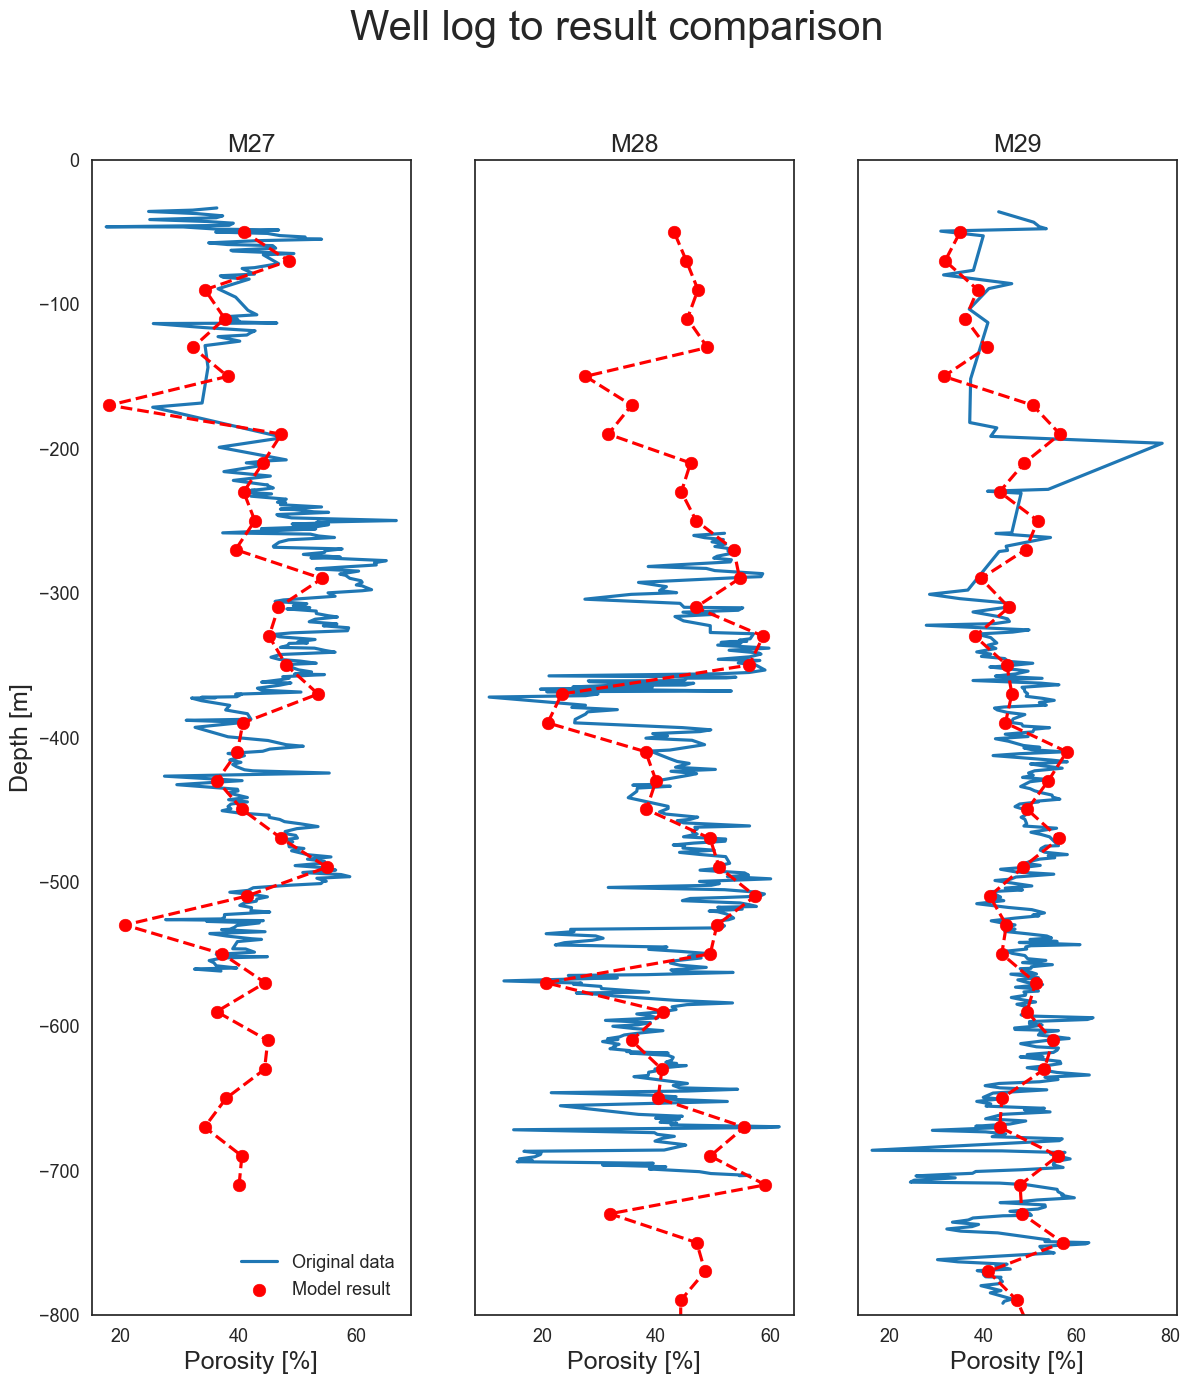

In [23]:
# Plot well comparison
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14,15), sharey=True)
fig.suptitle("Well log to result comparison", fontsize=30)

ax[0].set_title('M27',fontsize='18')
ax[0].plot(df[df["Well"]=="m27"]["Porosity"], df[df["Well"]=="m27"]["Z"], label="Original data")
ax[0].plot(resM27["Porosity"], resM27["Z"], color='r', linestyle="dashed")
ax[0].scatter(resM27["Porosity"], resM27["Z"], color='r', label="Model result", zorder=100)
ax[0].set_xlabel('Porosity [%]',fontsize='18')
ax[0].set_ylabel('Depth [m]',fontsize='18')
ax[0].legend(loc=4)
ax[0].set_ylim(-800,0)

ax[1].set_title('M28',fontsize='18')
ax[1].plot(df[df["Well"]=="m28"]["Porosity"], df[df["Well"]=="m28"]["Z"], label="Original data")
ax[1].plot(resM28["Porosity"], resM28["Z"], color='r', linestyle="dashed")
ax[1].scatter(resM28["Porosity"], resM28["Z"], color='r', label="Model result", zorder=100)
ax[1].set_xlabel('Porosity [%]',fontsize='18')
#ax[1].legend(loc=4)

ax[2].set_title('M29',fontsize='18')
ax[2].plot(df[df["Well"]=="m29"]["Porosity"], df[df["Well"]=="m29"]["Z"], label="Original data")
ax[2].plot(resM29["Porosity"], resM29["Z"], color='r', linestyle="dashed")
ax[2].scatter(resM29["Porosity"], resM29["Z"], color='r', label="Model result", zorder=100)
ax[2].set_xlabel('Porosity [%]',fontsize='18')
#ax[2].legend(loc=4)

#fig.savefig("Figures/Well_log_comparison_M28blind.png",dpi=450,bbox_inches='tight')

# A blind test comparison
In this section, we show the results of two realizations. One model result was generated using all 3 available wells. The blind model result was generated with only two wells, M27 and M29. 

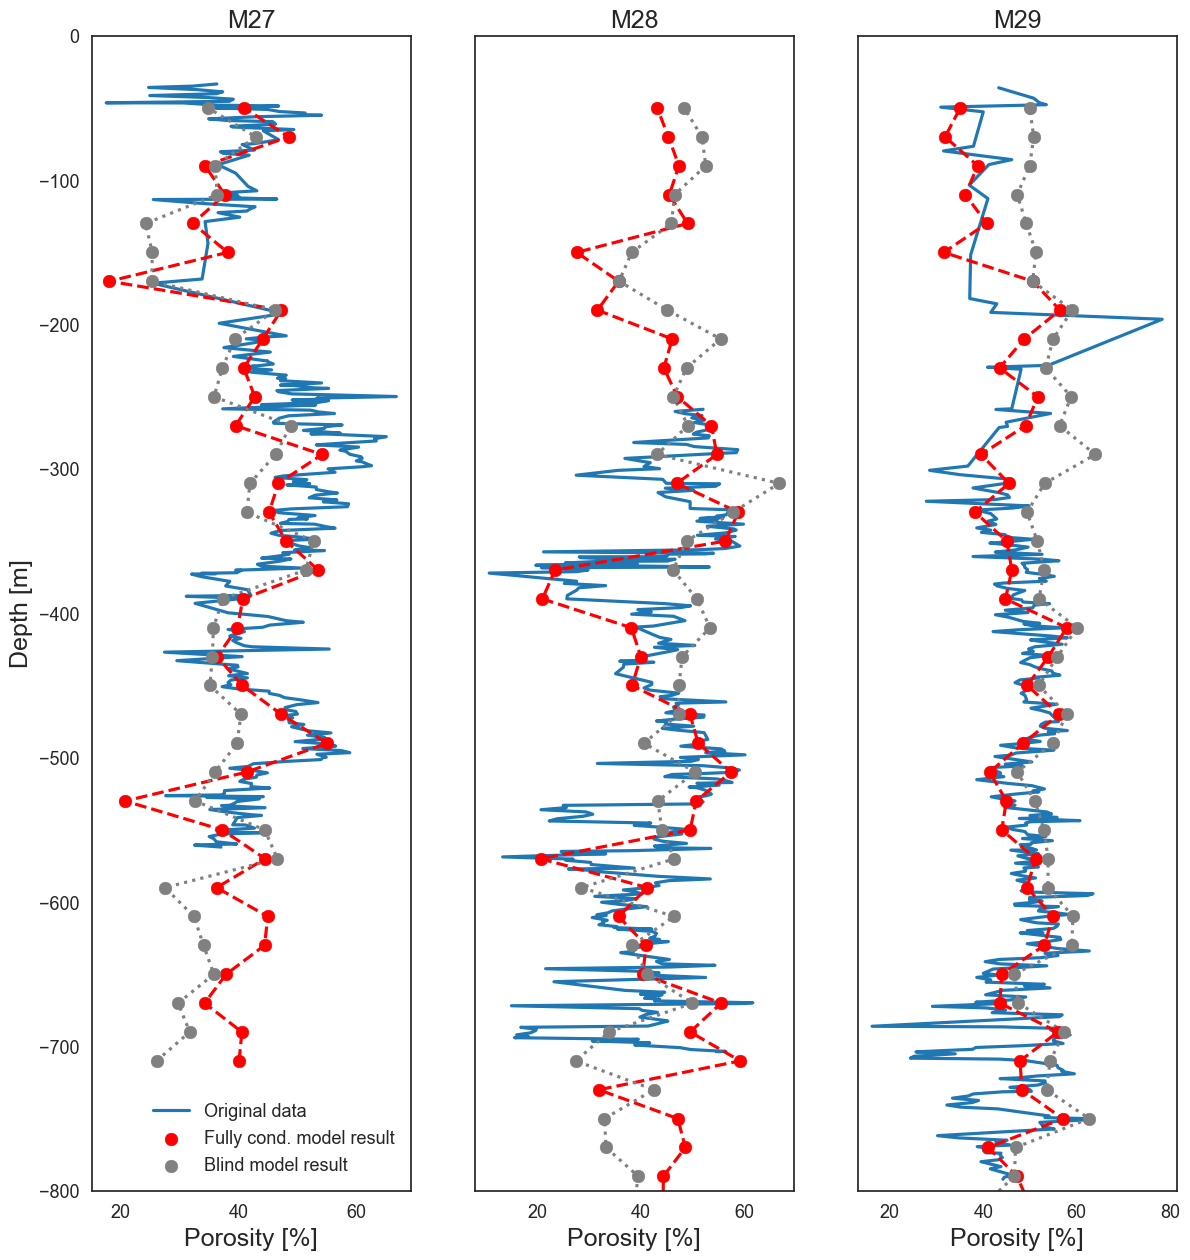

In [24]:
results_df = pd.read_csv("Results/Model_realization_20210728.csv")
blindresults_df = pd.read_csv("Results/Model_realization_20220228.csv")

# Mask by closest grid location
maskM27 = (results_df["X"].values==27250) & (results_df["Y"].values==59250)
maskM28 = (results_df["X"].values==28250) & (results_df["Y"].values==76250)
maskM29 = (results_df["X"].values==28750) & (results_df["Y"].values==87750)
maskM27b = (blindresults_df["X"].values==27250) & (blindresults_df["Y"].values==59250)
maskM28b = (blindresults_df["X"].values==28250) & (blindresults_df["Y"].values==76250)
maskM29b = (blindresults_df["X"].values==28750) & (blindresults_df["Y"].values==87750)
# Mask and sort
resM27 = results_df[maskM27].sort_values("Z")
resM28 = results_df[maskM28].sort_values("Z")
resM29 = results_df[maskM29].sort_values("Z")
resM27b = blindresults_df[maskM27b].sort_values("Z")
resM28b = blindresults_df[maskM28b].sort_values("Z")
resM29b = blindresults_df[maskM29b].sort_values("Z")
df = df.sort_values("Z")

# Plot well comparison of 2 control wells vs 3 control wells
fig2, ax = plt.subplots(nrows=1, ncols=3, figsize=(14,15), sharey=True)
#fig2.suptitle("Well log to result comparison", fontsize=30)

ax[0].set_title('M27',fontsize='18')
ax[0].plot(df[df["Well"]=="m27"]["Porosity"], df[df["Well"]=="m27"]["Z"], label="Original data")
ax[0].plot(resM27["Porosity"], resM27["Z"], color='r', linestyle="dashed")
ax[0].scatter(resM27["Porosity"], resM27["Z"], color='r', label="Fully cond. model result", zorder=100)
ax[0].plot(resM27b["Porosity"], resM27b["Z"], color='grey', linestyle=":")
ax[0].scatter(resM27b["Porosity"], resM27b["Z"], color='grey', label="Blind model result", zorder=100)

ax[0].set_xlabel('Porosity [%]',fontsize='18')
ax[0].set_ylabel('Depth [m]',fontsize='18')
ax[0].legend(loc=4)
ax[0].set_ylim(-800,0)


ax[1].set_title('M28',fontsize='18')
ax[1].plot(df[df["Well"]=="m28"]["Porosity"], df[df["Well"]=="m28"]["Z"], label="Original data")
ax[1].plot(resM28["Porosity"], resM28["Z"], color='r', linestyle="dashed")
ax[1].scatter(resM28["Porosity"], resM28["Z"], color='r', label="Fully cond. model result", zorder=100)
ax[1].plot(resM28b["Porosity"], resM28b["Z"], color='grey', linestyle=":")
ax[1].scatter(resM28b["Porosity"], resM28b["Z"], color='grey', label="Blind model result", zorder=100)

ax[1].set_xlabel('Porosity [%]',fontsize='18')
#ax[1].legend(loc=4)

ax[2].set_title('M29',fontsize='18')
ax[2].plot(df[df["Well"]=="m29"]["Porosity"], df[df["Well"]=="m29"]["Z"], label="Original data")
ax[2].plot(resM29["Porosity"], resM29["Z"], color='r', linestyle="dashed")
ax[2].scatter(resM29["Porosity"], resM29["Z"], color='r', label="Fully cond. model result", zorder=100)
ax[2].plot(resM29b["Porosity"], resM29b["Z"], color='grey', linestyle=":")
ax[2].scatter(resM29b["Porosity"], resM29b["Z"], color='grey', label="Blind model result", zorder=100)

ax[2].set_xlabel('Porosity [%]',fontsize='18')
#ax[2].legend(loc=4)

fig2.savefig("Figures/Well_log_comparison_blindtest.png",dpi=450,bbox_inches='tight')